# Performing the Higgs -> WW-> l leptons search 

##  Test performance of the XGB algorithm 

Focus on discriminating Higgs signal from irreducible SM WW production.

Final state is 2 leptons + missing tranverse momentum.

This notebooks shows the use of XGB for the analysis

# Installation of packages not available by default on colab


In [1]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib


!pip install vector
#!pip install hist

Defaulting to user installation because normal site-packages is not writeable


## Import packages used in the analysis

We're going to be using a number of tools to help us:
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:

import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


## Read in csv files for signal and background

In [3]:
fn2="https://cernbox.cern.ch/remote.php/dav/public-files/6mTuRapglPXnwUT/hww_atlas.csv.gz" #hww
totf2=600000
#fn1="https://cernbox.cern.ch/remote.php/dav/public-files/bt9p3KS952M0I11/ttlep_atlas.csv.gz" #ttlep
fn1="https://cernbox.cern.ch/remote.php/dav/public-files/ndKtAQHMxNUmumC/ww_atlas.csv.gz" #ww
totf1=600000

N = 50000
print("Size of dataset : %i"%N)
df1 = pd.read_csv(fn1, compression='gzip', header=0,nrows=N,engine='python')
df2 = pd.read_csv(fn2, compression='gzip', header=0,nrows=N,engine='python')

Size of dataset : 50000


In [4]:
print(df1.shape)
print(df2.shape)

(50000, 16)
(50000, 16)


## Add labelling and high-level variables

The csv files only contain the 4-vectors of the two leptons. In order to perform analysis:

* Label whether each sample is signal or background
* concatenate samples
* store 4-vectors of leptons amd etmiss in 'vector' structures for manipulation
* build high-level variables
* drop redundant ones

In [5]:
# add labelling signal/background
df1['SIG']=0
df2['SIG']=1


dftot=pd.concat([df1,df2])

#
# create array of 4-vectors of two leptons and etmiss for calculation of derived
# variables
#
p4l1=vector.array({"pt":dftot["ptl1"], "phi":dftot["phil1"],
    "eta":dftot["etal1"], "e":dftot["el1"]})
p4l2=vector.array({"pt":dftot["ptl2"], "phi":dftot["phil2"],
    "eta":dftot["etal2"], "e":dftot["el2"]})
etmv=vector.array({"pt":dftot["met_et"], "phi":dftot["met_phi"]})

#
#  rotate variables to exploit azimuthal symmetry
#
dftot["dphil1m"]=p4l1.deltaphi(etmv)
dftot["dphil2m"]=p4l2.deltaphi(etmv)

#  High level variables for 2-l+etm system
#
p4ll=p4l1+p4l2
dftot["dphill"]=p4l1.deltaphi(p4l2)
dftot["dphillm"]=p4ll.deltaphi(etmv)
ptll=p4ll.pt
mll=p4ll.M
dftot["ptll"]=ptll
dftot["mll"]=mll
#
#  transverse mass of decaying particle
#
etm=dftot["met_et"]
ptllv=vector.array({"x":p4ll.x, "y":p4ll.y})
c2=(etmv.x+ptllv.x)**2+(etmv.y+ptllv.y)**2
etll=np.sqrt(ptll*ptll+mll*mll)
c1=(etll+etm)**2
mt=np.sqrt(c1-c2)
dftot["mt"]=mt
#
#   drop redundant variables
#
df=dftot.drop(columns=['phil1','phil2','met_phi'])

#coln=df.columns

#print(coln)

#print(df.head())

#print(df.info())

## Look at signal and background statistics after reading data

In [6]:
def getnormev(df,totsig,totbg,evread):
  nsigw=((df.query("SIG==1"))["totalWeight"]).sum()*totsig/evread
  nbgw=((df.query("SIG==0"))["totalWeight"]).sum()*totbg/evread
  return nsigw,nbgw

nsigw,nbgw=getnormev(df,totf2,totf1,N)
print(nsigw,nbgw)

472.77396899039974 26427.228577091635


## Calculation of significance before selection

In [7]:
from math import sqrt, log
def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

In [8]:
print("significance is ",calc_sig(nsigw,nbgw,0.01*nbgw))

significance is  1.515984681366236


## Define dataframe with variables to be used for training

Dataframe will also contain flag on whether it is signal and background ('SIG') and weight for normalisation to LHC statistics ('totalWeight')

We randomize the sample. This is not needed, as the splitting in the next cell will mix events

In [9]:
tfea = ['SIG','ptl1','ptl2','dphil1m','dphil2m','etal1','etal2','met_et','mll','ptll','dphill','dphillm','mt','totalWeight'] # list of features for discriminant analysis
df_all=df[tfea]
df_all.columns=tfea
#print(df_all.keys)
# randomize it
df_all=df_all.sample(frac=1)

print("df_all ", df_all.shape)


df_all  (100000, 14)


## Definition of training and test samples

As usual use train_test_split from sklearn library
Two steps:

* Split out a 25% test sample to use at the end for performance evaluation:  X_testu
* Remaining 75% split into a 90% training sample and 10% validation sample to be used during training: X_trainu, X_valu

In [10]:
from sklearn.model_selection import train_test_split
#Define vectors for input to ML

# Use 'SIG' column as definition of target
y = df_all['SIG']

# drop it from dataframe for
X = df_all[[col for col in df_all.columns if col!="SIG"]]
col_fin=X.columns
print(col_fin)
print(X.shape)

# now split out test saple for final performance evaluations

X_traina, X_testu, y_traina, y_test = train_test_split(X, y,
                                   test_size=.25, random_state=0)

# save in X_testw test sample with weights included

X_testw=X_testu

# now further split train sample in actual train and validation

X_trainu, X_valu, y_train, y_val = train_test_split(X_traina, y_traina,
                                   test_size=.10, random_state=0)


# drop weighths 

X_trainu=X_trainu[[col for col in X_trainu.columns if col!="totalWeight"]]
X_testu=X_testu[[col for col in X_testu.columns if col!="totalWeight"]]
X_valu=X_valu[[col for col in X_valu.columns if col!="totalWeight"]]

print(X_trainu.columns)
print(X_trainu.shape)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'ptll', 'dphill', 'dphillm', 'mt', 'totalWeight'],
      dtype='object')
(100000, 13)
Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'ptll', 'dphill', 'dphillm', 'mt'],
      dtype='object')
(67500, 12)


## Scaling of samples so that all of the variables  are in the same range

Needed to make life easier for ML<br />
Use StandardScaler method from sklearn library

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler
print(X_trainu.columns)
# Fit only to the training data
scaler.fit(X_trainu)

# Now apply the transformations to the data:
X_train = scaler.transform(X_trainu)
X_test = scaler.transform(X_testu)
X_test=pd.DataFrame(X_test)
X_val=scaler.transform(X_valu)
print('train ', X_train.shape)
dfy=pd.DataFrame(y_train)
print('ytrain nbg',dfy.query("SIG==0").shape,'ytrain nsig',dfy.query("SIG==1").shape)
print('test', X_test.shape)
print('val', X_val.shape)

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'ptll', 'dphill', 'dphillm', 'mt'],
      dtype='object')
train  (67500, 12)
ytrain nbg (33702, 1) ytrain nsig (33798, 1)
test (25000, 12)
val (7500, 12)


# Run XGBOOST
https://xgboost.readthedocs.io/en/stable/index.html
eXtreme Gradient BOOST  

In [12]:
import xgboost as xgb  
import time
print(xgb.__version__)

XGBclassifier = xgb.sklearn.XGBClassifier(nthread=7, seed=1, 
                                          objective='binary:logistic', 
                                          use_label_encoder=False,
                                          eta=0.05, max_depth=3, reg_lambda=1, 
                                          n_estimators=300)
#Train and time classifier
start_time = time.time()
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBclassifier.fit(X_train, y_train, eval_metric=["logloss"], 
                  eval_set=eval_set,verbose=True  )
run_time = time.time() - start_time

#XGBclassifier.save_model('xgb_test')
Ypredr= XGBclassifier.predict_proba(X_test)[:,1]


2.0.3
[0]	validation_0-logloss:0.66696	validation_1-logloss:0.66695
[1]	validation_0-logloss:0.64329	validation_1-logloss:0.64326
[2]	validation_0-logloss:0.62173	validation_1-logloss:0.62178
[3]	validation_0-logloss:0.60211	validation_1-logloss:0.60219
[4]	validation_0-logloss:0.58427	validation_1-logloss:0.58432
[5]	validation_0-logloss:0.56782	validation_1-logloss:0.56794
[6]	validation_0-logloss:0.55277	validation_1-logloss:0.55283
[7]	validation_0-logloss:0.53896	validation_1-logloss:0.53895
[8]	validation_0-logloss:0.52610	validation_1-logloss:0.52628
[9]	validation_0-logloss:0.51438	validation_1-logloss:0.51449
[10]	validation_0-logloss:0.50353	validation_1-logloss:0.50365
[11]	validation_0-logloss:0.49328	validation_1-logloss:0.49348
[12]	validation_0-logloss:0.48399	validation_1-logloss:0.48414
[13]	validation_0-logloss:0.47532	validation_1-logloss:0.47544
[14]	validation_0-logloss:0.46731	validation_1-logloss:0.46737
[15]	validation_0-logloss:0.45951	validation_1-logloss:0.45

/home/polesell/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.39357	validation_1-logloss:0.39382
[30]	validation_0-logloss:0.39076	validation_1-logloss:0.39103
[31]	validation_0-logloss:0.38818	validation_1-logloss:0.38847
[32]	validation_0-logloss:0.38567	validation_1-logloss:0.38599
[33]	validation_0-logloss:0.38333	validation_1-logloss:0.38368
[34]	validation_0-logloss:0.38118	validation_1-logloss:0.38154
[35]	validation_0-logloss:0.37912	validation_1-logloss:0.37947
[36]	validation_0-logloss:0.37720	validation_1-logloss:0.37756
[37]	validation_0-logloss:0.37541	validation_1-logloss:0.37575
[38]	validation_0-logloss:0.37365	validation_1-logloss:0.37403
[39]	validation_0-logloss:0.37204	validation_1-logloss:0.37242
[40]	validation_0-logloss:0.37049	validation_1-logloss:0.37085
[41]	validation_0-logloss:0.36906	validation_1-logloss:0.36944
[42]	validation_0-logloss:0.36766	validation_1-logloss:0.36807
[43]	validation_0-logloss:0.36632	validation_1-logloss:0.36679
[44]	validation_0-logloss:0.36510	validation_1-logloss:

[159]	validation_0-logloss:0.33548	validation_1-logloss:0.33874
[160]	validation_0-logloss:0.33542	validation_1-logloss:0.33872
[161]	validation_0-logloss:0.33538	validation_1-logloss:0.33869
[162]	validation_0-logloss:0.33533	validation_1-logloss:0.33868
[163]	validation_0-logloss:0.33528	validation_1-logloss:0.33864
[164]	validation_0-logloss:0.33522	validation_1-logloss:0.33861
[165]	validation_0-logloss:0.33517	validation_1-logloss:0.33858
[166]	validation_0-logloss:0.33508	validation_1-logloss:0.33852
[167]	validation_0-logloss:0.33500	validation_1-logloss:0.33849
[168]	validation_0-logloss:0.33495	validation_1-logloss:0.33846
[169]	validation_0-logloss:0.33491	validation_1-logloss:0.33844
[170]	validation_0-logloss:0.33487	validation_1-logloss:0.33843
[171]	validation_0-logloss:0.33483	validation_1-logloss:0.33839
[172]	validation_0-logloss:0.33476	validation_1-logloss:0.33837
[173]	validation_0-logloss:0.33473	validation_1-logloss:0.33835
[174]	validation_0-logloss:0.33465	valid

[288]	validation_0-logloss:0.33040	validation_1-logloss:0.33658
[289]	validation_0-logloss:0.33038	validation_1-logloss:0.33656
[290]	validation_0-logloss:0.33034	validation_1-logloss:0.33655
[291]	validation_0-logloss:0.33033	validation_1-logloss:0.33656
[292]	validation_0-logloss:0.33031	validation_1-logloss:0.33656
[293]	validation_0-logloss:0.33028	validation_1-logloss:0.33655
[294]	validation_0-logloss:0.33026	validation_1-logloss:0.33654
[295]	validation_0-logloss:0.33021	validation_1-logloss:0.33655
[296]	validation_0-logloss:0.33019	validation_1-logloss:0.33655
[297]	validation_0-logloss:0.33015	validation_1-logloss:0.33653
[298]	validation_0-logloss:0.33012	validation_1-logloss:0.33652
[299]	validation_0-logloss:0.33009	validation_1-logloss:0.33650


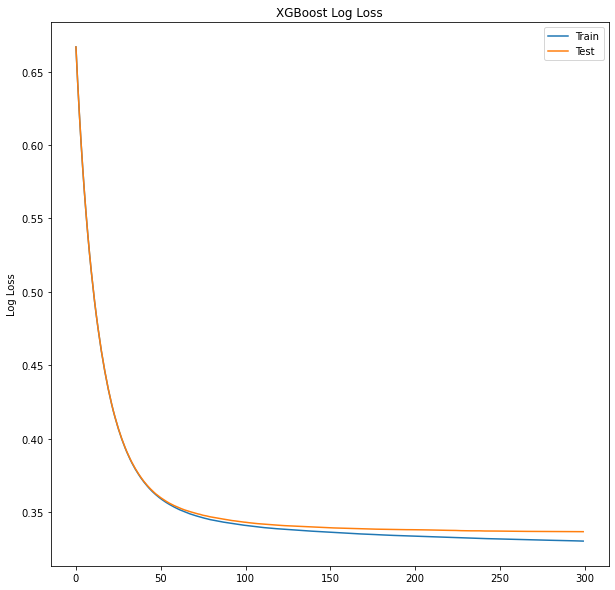

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'ptll', 'dphill', 'dphillm', 'mt'],
      dtype='object')


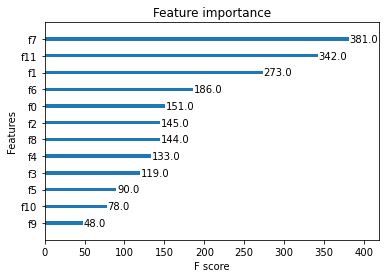

In [13]:

results = XGBclassifier.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

print(X_trainu.columns)

xgb.plot_importance(XGBclassifier,grid=False);

## Create dataframe with labels, probabilities  and normalisation weights

In [14]:
print(Ypredr.shape)
df_test_acc_r=X_testw.copy()
df_test_acc_r['SIG']=y_test
df_test_acc_r['PROB']=Ypredr


(25000,)


# Look at the classification performance

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.
This is done in order to understand on which variables the network leveraged for the classification


nsig  12459
nbkg  12541


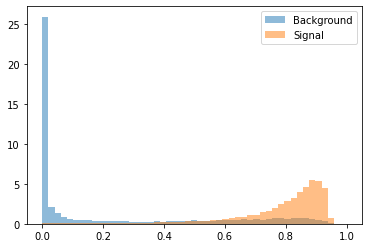

In [15]:
# split according to the label
df_test_acc_r_bkg = df_test_acc_r.query('SIG==0')
df_test_acc_r_sig = df_test_acc_r.query('SIG==1')
print('nsig ',df_test_acc_r_sig.shape[0])
print('nbkg ',df_test_acc_r_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_r_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_r_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC
In order to perform our the final selection we put a lower limit on the value of the probability and we count the fraction of events above this limit for both signal and backround, i.e for each value of PROB we have two values: The 'true positive rate (TPR)' (efficiency of signal selection in HEP language), and 'false positive rate (FPR)' (efficency for selecting background). If we TPR versus FPR the other as a function of PROB we obtain a curve called the Receive Operating Characteristic (ROC) curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Methods for building the ROC curve are availabel in sklearn.metrics. An ideal ROC curve would be along upper x and left y axes of the plot, corresponding to the case where all of the signal events have PROB=1 and all background events have PROB=0. The worst case is a curve where TPR=FPR, i.e. the discrimination power is the same as extracting a random number for PROB.

XGB auc  0.9135549739898322


<function matplotlib.pyplot.show(close=None, block=None)>

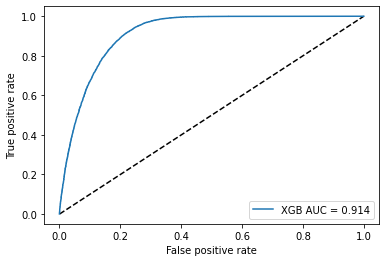

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredr)
auc_keras = auc(fpr_keras, tpr_keras)
print("XGB auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='XGB AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


# Calculate signal significance after selection

The output of the 'roc_curve' function is made of three vectors:

 * a vector with number of events 'SIG=0' with 'PROB' above threshold (false positives)
 * a vector with number of events 'SIG=1' with 'PROB' above threshold (true positives)
 * a vector of thresholds on 'PROB'
 
We loop on the vector of thresholds, and for each threshold we calculate the number of signal and background events normalised to the LHC statistics, and on the basis of that we calculate significance

In [17]:
from numpy import nanmax
#   calculate significance for a discriminator yielding
#   predictions Ypredt for labels y_test, assuming
#   nsigtot:  number of signal events before selection
#   nbgtot: nuber of background events before selection
#   errfbg: fractional systematic uncertainty on background
#
def plot_signi_base(y_test, Ypredt, nsigtot, nbgtot, errfbg, lab):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  n_bg=fpr_keras*nbgtot
  n_sig=tpr_keras*nsigtot
  errbg=errfbg*n_bg
  signi=[]
  thr=[]      
  for i in range(1,len(n_sig)):
      if(thresholds_keras[i]>0.):
        signi.append(calc_sig(n_sig[i],n_bg[i],errbg[i]))
        thr.append(thresholds_keras[i])        
  imax=-1
  signimax=0.
  for i in range(0,len(signi)):
     if signi[i]>signimax:
        imax=i
        signimax=signi[i]  
  maxs=nanmax(signi)
  print(lab+":") 
  print(" max significance is  ",signimax," nbg ",n_bg[imax]," nsig ",n_sig[imax]," cut ",thresholds_keras[imax])
  print(" background efficiency: ", n_bg[imax]/nbgtot," signal efficiency: ", n_sig[imax]/nsigtot )
  plt.plot(thr,signi, label=lab)
    
  plt.xlabel('Cut on PROB')
  plt.ylabel('Significance')


  return thr, signi, imax


  

In [18]:
nsigw,nbgw=getnormev(df_test_acc_r,totf2,totf1,N)
print(nsigw,nbgw)

117.83242200839999 6581.7841314888


nbg 6581.7841314888:
 max significance is   2.9437591440873376  nbg  603.5445140907519  nsig  75.8595278055523  cut  0.790428
 background efficiency:  0.09169922653695878  signal efficiency:  0.6437916365679428


<function matplotlib.pyplot.show(close=None, block=None)>

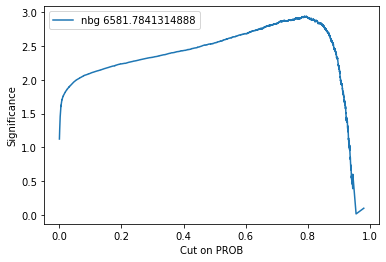

In [19]:
# The background estimate has a systematic  uncertainty  which is expressed as a fraction of background events
# we use 1% 
bfr=0.01
thr, signi, imax=plot_signi_base(y_test, Ypredr,nsigw,nbgw,bfr, 'nbg '+str(nbgw))
plt.legend(loc='best')
plt.show

## Compare label and prediction in 1-d projections

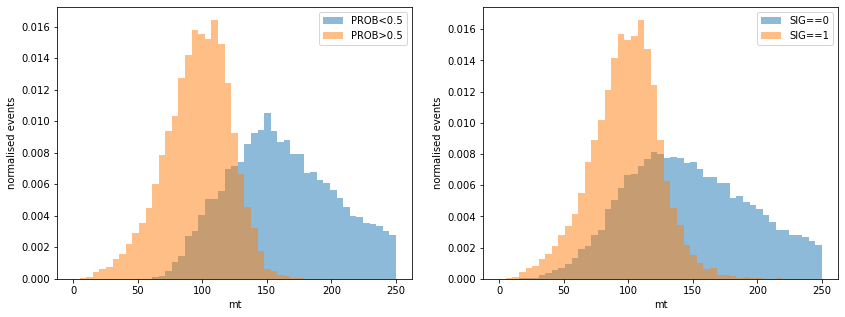

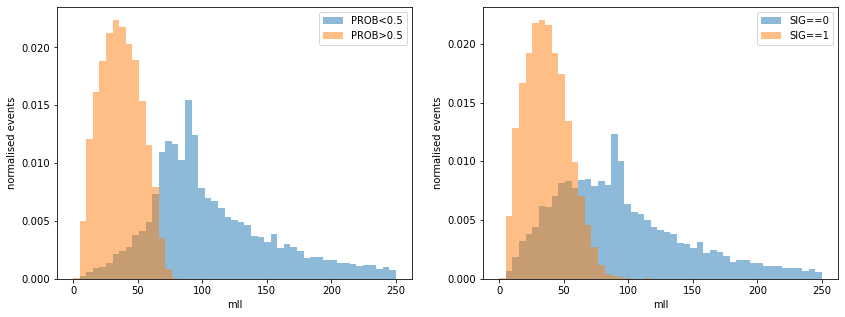

In [20]:
MeV=0.001
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
blow=0.
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="mt"
varmin=0.
varmax=250.
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
plt.hist(df_test_acc_r.query(pred_false)[var]*scale, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var]*scale, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var]*MeV, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var]*MeV, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
var="mll"
varmin=0.
varmax=250
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist(df_test_acc_r.query(pred_false)[var]*MeV, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var]*MeV, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var]*MeV, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var]*MeV, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

## Compare label and prediction in 2-d projections

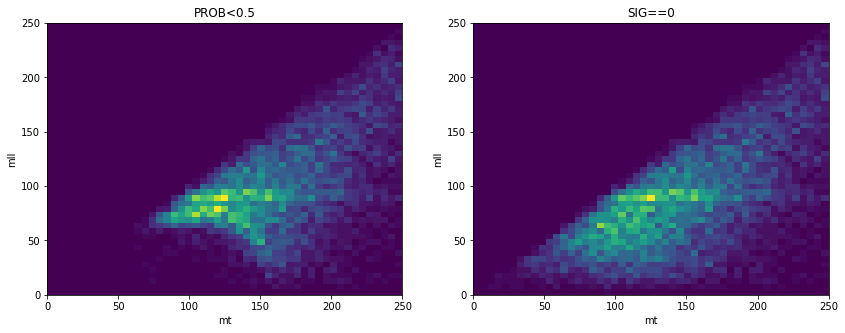

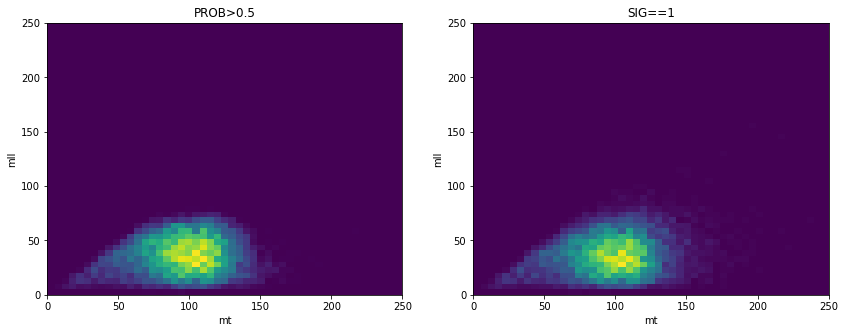

In [21]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
varx="mt"
varminx=0.
varmaxx=250.
nbinx=50
scalex=MeV
vary="mll"
nbiny=50
varminy=0.
varmaxy=250
scaley=MeV
binx = np.linspace(varminx,varmaxx,nbinx)
biny = np.linspace(varminy,varmaxy,nbiny)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_r.query(pred_false)[varx]*scalex, df_test_acc_r.query(pred_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_false)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_r.query(lab_false)[varx]*scalex, df_test_acc_r.query(lab_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_false)
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_r.query(pred_true)[varx]*scalex, df_test_acc_r.query(pred_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_true)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_r.query(lab_true)[varx]*scalex, df_test_acc_r.query(lab_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_true)
plt.show()

# Exercises

Exercises:
* Study performance of XGB by playing with hyperparameters
  * eta 
  * max_depth 
  * reg_lambda
  * n_estimators
* Study performance by removing variables with least importance
  